In [1]:
import pandas as pd
import numpy as np
import re
import time
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_csv("df_all.csv", usecols=["reviewText", "gender", "category", "reviewerName"])
df.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 4 entries, reviewerName to category
dtypes: object(4)
memory usage: 361.6 MB


In [3]:
#df.groupby(["reviewerID", "reviewerName"])["reviewerName"].count().sort_values()
category_list = list(np.unique(df.category))
print(category_list)
df.head()

['Automotive', 'Books', 'CDs', 'Cell', 'Clothing', 'Electronics', 'Grocery', 'Home', 'Kindle', 'Movies', 'Office', 'Patio', 'Pet', 'Sports', 'Tools', 'Toys']


reviewerName                                         reviewText gender  \
0             James  Just as described, they have a hole in the bot...   male   
1             denny  I will give it five stars because it deserves ...   male   
2  anthony maslanka  Good story development an character interactio...   male   
3          LAWRENCE  HAVE USED FOR MANY YEARS, GREAT PRODUCT 350k T...   male   
4         Keith Eck  Just the right size and protection for the sno...   male   

     category  
0       Patio  
1      Kindle  
2      Kindle  
3  Automotive  
4       Patio

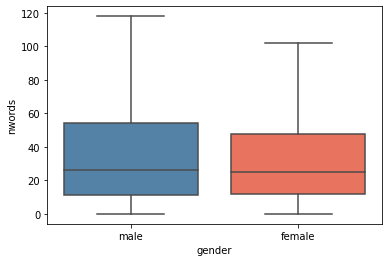

In [4]:
def preprocess_review(review):
    review = review.replace("&ea", "&").replace("'", "")
    review = re.findall("[.]+|[A-Za-z]+|[!]+|[&]+|[\n]", review)
    return review

df["review"] = df.reviewText.apply(lambda review: preprocess_review(review))
df["nwords"] = df.review.apply(lambda word_list: len(word_list))

ax = sns.boxplot(x="gender", y="nwords", data=df, order=["male", "female"], showfliers=False, palette=["steelblue", "tomato"])
plt.savefig(os.path.join("figures", "gender_nwords.png"), dpi=1200)


#for each category
# number of differnt words in each category for male/female?

In [5]:
category_list

['Automotive',
 'Books',
 'CDs',
 'Cell',
 'Clothing',
 'Electronics',
 'Grocery',
 'Home',
 'Kindle',
 'Movies',
 'Office',
 'Patio',
 'Pet',
 'Sports',
 'Tools',
 'Toys']

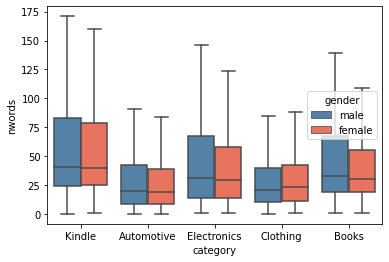

In [6]:
ax = sns.boxplot(x="category", y="nwords", data=df[df.category.isin(["Books","Clothing", "Electronics", "Automotive", "Kindle"])], hue="gender",showfliers=False, palette=["steelblue", "tomato"])
plt.savefig(os.path.join("figures", "gender_nwords.png"), dpi=1200)

In [7]:
df.review = df.review.apply(lambda text: text[:150])
df["nwords"] = df.review.apply(lambda word_list: len(word_list))
df = df[df.nwords != 0]
df.nwords.max()

150

In [8]:
df.review

0         [Just, as, described, they, have, a, hole, in,...
1         [I, will, give, it, five, stars, because, it, ...
2         [Good, story, development, an, character, inte...
3         [HAVE, USED, FOR, MANY, YEARS, GREAT, PRODUCT,...
4         [Just, the, right, size, and, protection, for,...
                                ...                        
799995    [Classic, funny, moments, ., Arnold, &, Jamie,...
799996    [Its, hard, to, find, a, powder, blue, seat, t...
799997    [Follow, the, directions, and, they, are, good...
799998      [Its, the, perfect, length, for, my, office, .]
799999    [Not, much, else, to, say, except, that, this,...
Name: review, Length: 799959, dtype: object

In [9]:
# # only works in case of feature matrix idf-tf etc.(order doesnt matter)
# remove_words = set(["husband", "husbands", "wife", "wifes", "boyfriend", "boyfriends", "girlfriend", "girlfiend","girlfriends"])
# # maybe also replace He, She etc with neutral pronouns
# df.review = df.review.apply(lambda text: list(set(text)- remove_words))
# df.review

remove_words = ["husband", "husbands", "wife", "wifes", "boyfriend", "boyfriends", "girlfriend", "girlfiend","girlfriends"]
df.review = df.review.apply(lambda words: [word for word in words if word not in remove_words])

In [10]:
df.review

0         [Just, as, described, they, have, a, hole, in,...
1         [I, will, give, it, five, stars, because, it, ...
2         [Good, story, development, an, character, inte...
3         [HAVE, USED, FOR, MANY, YEARS, GREAT, PRODUCT,...
4         [Just, the, right, size, and, protection, for,...
                                ...                        
799995    [Classic, funny, moments, ., Arnold, &, Jamie,...
799996    [Its, hard, to, find, a, powder, blue, seat, t...
799997    [Follow, the, directions, and, they, are, good...
799998      [Its, the, perfect, length, for, my, office, .]
799999    [Not, much, else, to, say, except, that, this,...
Name: review, Length: 799959, dtype: object

In [11]:
def balance_gender(X, nmax, seed=20):
    nrows = len(X)  
    males = X[X.gender == "male"]
    females = X[X.gender == "female"]
    n = len(males)
    if n > len(X)/2:
        n = nrows-n
    if n > nmax:
        n = nmax
    nMales = males.sample(n=n, random_state=seed, replace=False)
    nFemales = females.sample(n=n, random_state=seed, replace=False)
    balanced_X = pd.concat([nMales,nFemales], axis=0)
    return balanced_X.sample(frac=1, random_state=seed, replace= False)
def create_idf_dict(series):
    dictionary = dict()
    for bag_of_words in series:
        no_duplicates = list(dict.fromkeys(bag_of_words))
        #print(no_duplicates)
        for word in no_duplicates:
            insert(dictionary, word)
    return dictionary

def insert(dictionary, word):
    if word in dictionary:
        dictionary[word] += 1
    else:
        dictionary[word] = 1

def build_feature_matrix(reviews, f_words):
    fm = list()
    for review in reviews:
        counter = Counter(review)
        fm.append([counter[word] for word in f_words.index])
    fm_df = pd.DataFrame(data=fm, index=reviews.index, columns=f_words.index)
    nwords = reviews.apply(lambda text: len(text))
    fm_df = fm_df.div(nwords, axis=0)
    # for i in range(len(data)):
    #     counter = Counter(data.X.iloc[i])
    #     fm.iloc[i] = [counter[word] for word in f_words]
    fm_df = fm_df * f_words.scores
    return fm_df

## Use gensim library

In [12]:
import multiprocessing

from gensim.models import Word2Vec
from gensim.models import Phrases


# # Train a bigram detector.

# bigram_transformer = Phrases(df.review)

# # Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.

# w2v = Word2Vec(bigram_transformer[df.review], min_count=10)


#w2v.wv.most_similar("LOVE")

In [13]:
df = balance_gender(df, len(df))

X_train, X_test, y_train, y_test = train_test_split(df.review, df.gender, test_size=0.3,
                                                        random_state=42, stratify=df.gender)

intersection_word_set = {}
for category in category_list:
    print("-----------", category, "-----------")
    w2v_model = Word2Vec(min_count=50)
    w2v_model.build_vocab(X_train[df.category==category])
    #w2v_model.wv.key_to_index[:3]
#     print(list(w2v_model.wv.key_to_index.items())[0])
    print(len(w2v_model.wv.key_to_index))
    list(w2v_model.wv.key_to_index.keys())
    if len(intersection_word_set)==0:
        intersection_word_set = set(w2v_model.wv.key_to_index.keys())
    else:
        intersection_word_set = set(w2v_model.wv.key_to_index.keys()).intersection(intersection_word_set)
    
# words occurence at least 0.01 %    

----------- Automotive -----------
1922
----------- Books -----------
2387
----------- CDs -----------
2160
----------- Cell -----------
1854
----------- Clothing -----------
1572
----------- Electronics -----------
2358
----------- Grocery -----------
1791
----------- Home -----------
2088
----------- Kindle -----------
2658
----------- Movies -----------
1959
----------- Office -----------
2004
----------- Patio -----------
2052
----------- Pet -----------
2138
----------- Sports -----------
2135
----------- Tools -----------
2169
----------- Toys -----------
1793


In [14]:
# # different words used by males and females
# xs = []
# ys = []
# for category in ["Automotive", "Books", "Clothing"]:
#     print("-----------", category, "-----------")
#     w2v_model = Word2Vec(min_count=10)
#     w2v_model.build_vocab(X_train[df.category==category])
#     #w2v_model.wv.key_to_index[:3]
# #     print(list(w2v_model.wv.key_to_index.items())[0])
#     xs.append(category)
#     ys.append(len(w2v_model.wv.key_to_index))
#     sns.barplot(xs,ys)
#     plt.savefig(os.path.join("figures", "x.png"), dpi=1200)
    

In [15]:
print(len(intersection_word_set))
intersection_word_set

712


{'\n',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '&',
 '.',
 '..',
 '...',
 '....',
 '.....',
 'A',
 'AND',
 'After',
 'All',
 'Also',
 'Although',
 'Amazon',
 'And',
 'As',
 'At',
 'Awesome',
 'B',
 'BUT',
 'Best',
 'But',
 'Buy',
 'Can',
 'Cant',
 'Definitely',
 'Did',
 'Do',
 'Dont',
 'Even',
 'Everything',
 'Excellent',
 'FOR',
 'Fast',
 'First',
 'For',
 'GREAT',
 'Good',
 'Got',
 'Great',
 'Had',
 'Have',
 'He',
 'Highly',
 'However',
 'I',
 'IS',
 'IT',
 'Id',
 'If',
 'Ill',
 'Im',
 'In',
 'It',
 'Its',
 'Ive',
 'Just',
 'LOVE',
 'Like',
 'Love',
 'Maybe',
 'Most',
 'Much',
 'My',
 'NOT',
 'Nice',
 'No',
 'Not',
 'Nothing',
 'Now',
 'OK',
 'On',
 'Once',
 'One',
 'Only',
 'Other',
 'Overall',
 'Perfect',
 'Pretty',
 'Really',
 'S',
 'Since',
 'So',
 'Some',
 'Still',
 'THE',
 'THIS',
 'TO',
 'Thank',
 'Thanks',
 'That',
 'Thats',
 'The',
 'Then',
 'There',
 'These',
 'They',
 'This',
 'To',
 'Too',
 'Unfortunately',
 'VERY',
 'Very',
 'Was',
 'We',
 'Well',
 'What',
 'When',
 'While',
 'Wi

In [16]:
# idf-scores for intersection words

count_word_dict = create_idf_dict(X_train)
idf_scores = pd.DataFrame.from_dict(count_word_dict, orient="index")
idf_scores = idf_scores.loc[list(intersection_word_set)]
idf_scores = np.log2(len(X_train)/idf_scores).sort_values(by=0)[:2500]
idf_scores.columns = ["scores"]
# instead of using number of word occurrences i.e. 0.1% -> max id-score 9.966
idf_scores

scores
.            0.346359
the          0.897255
and          0.916637
I            1.130057
a            1.136284
...               ...
Worth        8.800341
considering  8.824666
fair         8.854170
impossible   8.867346
alot         8.925037

[712 rows x 1 columns]

In [17]:
t0 = time.time()
X_train_fm = build_feature_matrix(X_train, idf_scores)
X_test_fm = build_feature_matrix(X_test, idf_scores)
print("building feature matrix took: ", (time.time()-t0)/60, " minutes.")

building feature matrix took:  3.2981192827224732  minutes.


In [18]:
# X_train_fm.to_csv("Fm_train.csv")
# X_test_fm.to_csv("Fm_test.csv")
# df.to_csv("df_FM.csv")

## Logistic Regression on whole Dataset

In [19]:
from sklearn.linear_model import LogisticRegression
clfwd = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_fm, y_train)
y_predict = clfwd.predict(X_test_fm)
y_proba = clfwd.predict_proba(X_test_fm)
print(clfwd.score(X_test_fm, y_test))
print(clfwd.score(X_train_fm, y_train))

idf_scores["coef"] = clfwd.coef_[0]
typical_male_words = idf_scores.sort_values(by="coef")[-100:].index
typical_female_words = idf_scores.sort_values(by="coef")[:100].index

0.6112807990565998
0.6150861045183665


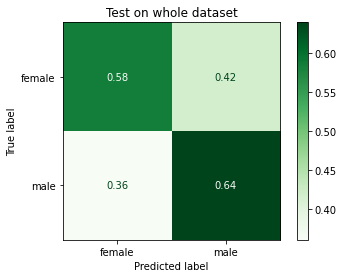

Accuracy: 0.6112807990565998


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clfwd, X_test_fm, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Greens,
                                 normalize="true")
disp.ax_.set_title("Test on whole dataset")
plt.show()

print("Accuracy:", clfwd.score(X_test_fm, y_test))

#print(disp.confusion_matrix)



In [21]:
typical_male_words[::-1]

Index(['\n', 'similar', 'far', 'likely', 'issue', 'version', 'third', 'may',
       'Overall', 'While', 'why', 'years', 'youll', 'At', 'nearly', 'solid',
       'check', 'B', 'near', 'of', 'expect', 'might', 'link', 'number',
       'probably', 'simply', 'If', 'recommended', 'After', 'fairly', 'bad',
       'With', 'minutes', 'compared', 'say', 'thing', 'mostly', 'decent', 'S',
       'saw', 'some', 'slightly', 'In', 'cost', 'stuff', 'believe', 'better',
       'four', 'problem', 'original', 'high', 'important', 'non', 'seems',
       'ask', 'experience', 'means', 'Then', 'point', 'those', 'feels', 're',
       'live', 'low', 'most', 'future', 'seem', 'break', 'opinion', 'simple',
       'should', 'control', 'good', 'plenty', 's', 'OK', 'overall', 'else',
       'For', 'itself', 'expecting', 'single', 'complaint', 'whatever', 'cool',
       'issues', 'suggest', 'main', 'what', 'any', 'available', 'finish',
       'from', 'second', 'if', 'an', 'Thats', 'last', 'Buy', 'buy'],
      dtype

In [22]:
typical_female_words

Index(['I', '.', 'so', 'her', 'He', 'and', 'because', '!', 'love', 'beautiful',
       'he', 'my', 'we', 'wait', 'to', 'for', 'We', 'was', 'Love', 'This',
       'didnt', 'such', 'put', 'So', 'who', 'this', 'disappointed', 'fall',
       'wasnt', 'family', 'picture', 'wonderful', 'It', 'myself', 'ended',
       'him', 'able', 'felt', 'outside', 'our', '&', 'room', 'were', 'sit',
       'gotten', 'definitely', 'within', 'LOVE', 'each', 'ordered', 'Im',
       'loved', 'couldnt', 'pretty', 'but', 'These', 'am', 'kind', 'true',
       'stay', 'she', 'white', 'They', 'Definitely', 'doesnt', 'did', 'are',
       'really', 'purchased', 'purchasing', 'had', 'My', 'everyone', 'usually',
       'case', 'kept', 'person', 'his', 'TO', 'gift', 'having', 'in',
       'favorite', 'all', 'arent', 'different', 'especially', 'off', 'ones',
       '!!', 'would', 'Will', 'too', 'Would', 'next', 'totally', 'actual',
       'absolutely', 'came', 'isnt'],
      dtype='object')

## Confusion Matrices per category trained on whole dataset

--------------- Automotive --------------


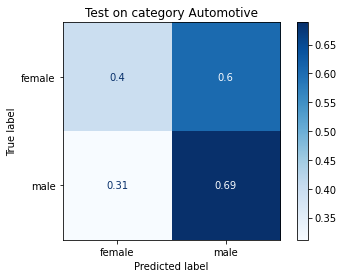

Accuracy: 0.5416527935006992




In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#for category in category_list:

for category in ["Automotive"]:

    print("---------------", category, "--------------")
    df_y_test = df.loc[y_test.index]
    index_test = df_y_test[df_y_test.category==category].index

    disp = plot_confusion_matrix(clfwd, X_test_fm.loc[index_test], y_test.loc[index_test],
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 #cmap=cma,
                                 normalize="true")
    disp.ax_.set_title("Test on category "+category)

    #print(disp.confusion_matrix)
    plt.show()


    print("Accuracy:", clfwd.score(X_test_fm.loc[index_test], y_test.loc[index_test]))

    print("\n")


Man kann sehen, dass hier ein gewisses Stereotyping entsteht. In der Kategie Automaotive werden eher Reviews weiblich zugeordnet, als männlich.
Die Frage ist woher kommt das? Das Modell weiß ja nicht, dass mehr Männer in Automaotive schreiben als Frauen. 

Um das weiter zu beobachten, kann man Reviews nehmen aus Electronics, die weiblich sind, aber mit hoher WAhrschienlichkeit männlich

In [24]:
for category in category_list:
#for category in ["Clothing"]:
    print("-------------", "\033[1m"+category + "\033[0m", "--------------")
    df_y_test = df.loc[y_test.index]
    index_test_cat_female = df_y_test[(df_y_test.category==category) &(df_y_test.gender=="female")].index
    index_test_cat_male = df_y_test[(df_y_test.category==category) &(df_y_test.gender=="male")].index


    predict_male = pd.Series(clfwd.predict_proba(X_test_fm.loc[index_test_cat_male])[:,1], index = index_test_cat_male)
    predict_female = pd.Series(clfwd.predict_proba(X_test_fm.loc[index_test_cat_female])[:,0], index = index_test_cat_female)


    # review from Electronic female that has very high score:
    index1, index2 = predict_female.sort_values(ascending=False)[:2].index
    print("\033[1m" + "Female, high score:" + "\033[0m")
    print(df.loc[index1].reviewerName, ": ", df.loc[index1].reviewText)
    print(df.loc[index2].reviewerName, ": ", df.loc[index2].reviewText)

    print("\n")

    # review from Electronic female that has very low score:
    index1, index2 = predict_female.sort_values(ascending=True)[:2].index
    print("\033[1m" + "Female, low score: " + "\033[0m")
    print(df.loc[index1].reviewerName, ": ", df.loc[index1].reviewText)
    print(df.loc[index2].reviewerName, ": ", df.loc[index2].reviewText)

    print("\n")

    # review from Electronics male that has very high score
    index1, index2 = predict_male.sort_values(ascending=False)[:2].index
    print("\033[1m" + "Male, high score: " + "\033[0m")
    print(df.loc[index1].reviewerName, ": ", df.loc[index1].reviewText)
    print(df.loc[index2].reviewerName, ": ", df.loc[index2].reviewText)
    print("\n")

    # review from Electronis male that has very low score
    index1, index2 = predict_male.sort_values(ascending=True)[:2].index
    print("\033[1m" + "Male, low score: " + "\033[0m")
    print(df.loc[index1].reviewerName, ": ", df.loc[index1].reviewText)
    print(df.loc[index2].reviewerName, ": ", df.loc[index2].reviewText)
    print("\n")

------------- Automotive --------------
Female, high score:
Constance Picha :  LOVE, LOVE, LOVE!
Geneva :  These look wonderful! Love them!


Female, low score: 
Cynthia Kareski :  a five star
Lori Bowling :  cool man


Male, high score: 
sebastien  narcisse :  solid material
Louis D. :  worked great fixed issue


Male, low score: 
bryan thomas :  beautiful product
Cas :  Love, love, love these!!!


------------- Books --------------
Female, high score:
penny snyder :  Love her humor
Karalyn Squiers :  didn't really love


Female, low score: 
Deborah Davis :  Just  OK
pamela :  some good patterns


Male, high score: 
Jordan Becher :  Has some decent information
Mitch :  Need I say more?

Syn- strong willed female lead
Ryder - Bad A$$ hottie you wanna lick

contains:

Awesome friends who have your back.
Angst
romance
sex
blood
sex
fighting
slight mysteries
sex
growling alpha male
fae
demons
vampires
fantasy
chiffhanger (so worth it)
and oh yeah... sex!

If you'd like a more in depth rev

In [25]:
index1, index2 = predict_female.sort_values(ascending=False)[:2].index

Reviews that are wrongly classified: 
could there be shared accounts?

There are still names that could be wrong: Sam, Joan

In [26]:
df["wife"] = df.review.apply(lambda text: True if( "wife" in text) or ("wifes" in text) or "husband" in text or "husbands" in text or "girlfriend" in text or "boyfriend" in text else False)
df.wife.sum()/len(df)

0.0

## Train Logistic Regression on only one category

In [27]:
df_y_train = df.loc[y_train.index]
index_train_electronics = df_y_train[df_y_train.category=="Electronics"].index


df_y_test = df.loc[y_test.index]
index_test_electronics = df_y_test[df_y_test.category=="Electronics"].index
from sklearn.linear_model import LogisticRegression
clfe = LogisticRegression(random_state=0, max_iter=500).fit(X_train_fm.loc[index_train_electronics], y_train.loc[index_train_electronics])

print(clfe.score(X_test_fm.loc[index_test_electronics], y_test.loc[index_test_electronics]))
print(clfe.score(X_train_fm.loc[index_train_electronics], y_train.loc[index_train_electronics]))

0.6195306284805091
0.6412041015065589


In [28]:
idf_scores["coef_category"] = clfe.coef_[0]
typical_elec_male_words = idf_scores.sort_values(by="coef_category")[-100:].index
typical_elec_female_words = idf_scores.sort_values(by="coef_category")[:100].index

['Clothing' 'CDs' 'Cell' 'Movies' 'Pet' 'Kindle' 'Toys' 'Home' 'Sports'
 'Grocery' 'Books' 'Tools' 'Office' 'Electronics' 'Automotive' 'Patio']

In [29]:
typical_elec_male_words[::-1]

Index(['finish', '\n', 'main', 'based', 'line', 'In', 'solid', 'between',
       'two', 'fan', 'until', 'house', 'surprised', 'single', 'make',
       'version', 'except', 'believe', 'mostly', 'say', 'nd', 'second',
       'minutes', 'almost', 'expect', 'similar', 'simply', 'coming', 'normal',
       'high', 'huge', 'bad', 'else', 'low', 'will', 'higher', 'over', 'given',
       'After', 'end', 'down', 'point', 'where', 'Some', 'thinking', 'five',
       'simple', 'full', 'far', 'run', 'most', 'four', 'home', 'standard',
       'seen', 'life', 'which', 'start', 'theyre', 'some', 'ask', 'likely',
       'own', 'there', 'issue', 'box', 'giving', 'problem', 'of', 'opinion',
       'any', 'While', 'both', 'better', 'straight', 'anyway', 'recommended',
       'Maybe', 'why', 'together', 'impressed', 'let', 'At', 'third', 'add',
       'plenty', 'through', 'old', 'B', 'Once', 'On', 'To', 'under', 'Amazon',
       'S', 'everyone', 'seem', 'issues', 'rest', 'plus'],
      dtype='object')

In [30]:
typical_elec_female_words 

Index(['We', 'I', 'his', '.', 'he', 'because', 'our', 'so', 'He', 'love', 'my',
       'we', 'beautiful', 'Love', '!', 'were', 'doesnt', 'taking', 'hands',
       'looked', 'year', 'for', 'My', 'usually', 'extra', 'amount', 'gift',
       'and', 'one', 'case', 'person', 'put', 'etc', 'often', 'someone', 'is',
       'keep', 'It', 'was', 'order', 'can', 'havent', 'him', 'take', 'glad',
       'find', 'turn', 'condition', 'longer', 'different', 'to', 'Yes', 'LOVE',
       'really', 'Its', 'am', '&', 'Not', 'sit', 'how', 'thought', 'kids',
       'out', 'when', 'takes', 'purchased', 'putting', 'ordered', 'use',
       'came', 'loved', 'like', 'us', 'it', 'received', 'within', 'outside',
       'she', 'around', 'open', 'Thank', 'something', 'dont', 'many', 'off',
       'whatever', 'easy', 'have', 'had', 'TO', 'watch', 'kept', 'wish',
       'look', 'me', 'has', 'ended', 'soon', 'always', 'wonderful'],
      dtype='object')

In [31]:
## 

In [32]:
# for category in category_list:
#     df["category_tmp"] = df.category.apply(lambda cat: category if cat==category else "other")
#     clf = LogisticRegression(random_state=0, max_iter=300).fit(X_train_fm, df.category_tmp.loc[y_train.index])
#     print("-------------------", category, "----------------")
#     print("train data score: ", clf.score(X_train_fm, df.category_tmp.loc[y_train.index]))
#     print("test data score: ", clf.score(X_test_fm, df.category_tmp.loc[y_test.index]))
#     print("\n")
#     idf_scores["coef"+category] = clf.coef_[0]
    

In [33]:
from sklearn.linear_model import LogisticRegression
clf_all = LogisticRegression(max_iter=1000).fit(X_train_fm, df.category.loc[y_train.index])

print(clf_all.score(X_test_fm, df.category.loc[y_test.index]))

# category is male/female if [75%] of the reviews are male/female
male_categories = []
female_categories =[]


0.3122262826950242


In [34]:
pd.unique(df.loc[X_train_fm.index].category)

array(['Kindle', 'Sports', 'Books', 'Office', 'Grocery', 'Patio', 'Toys',
       'Electronics', 'Automotive', 'Clothing', 'Pet', 'CDs', 'Tools',
       'Movies', 'Cell', 'Home'], dtype=object)

In [35]:
category_list

['Automotive',
 'Books',
 'CDs',
 'Cell',
 'Clothing',
 'Electronics',
 'Grocery',
 'Home',
 'Kindle',
 'Movies',
 'Office',
 'Patio',
 'Pet',
 'Sports',
 'Tools',
 'Toys']

In [36]:
for idx, category in enumerate(pd.unique(df.loc[X_train_fm.index].category)):
    idf_scores["coef"+category] = clf_all.coef_[idx]

In [37]:
for category in pd.unique(df.loc[X_train_fm.index].category):
    print("-----------", category, "------------")
    print(idf_scores[["coef"+category]].sort_values(by="coef"+category)[:50])

----------- Kindle ------------
           coefKindle
her         -5.538538
I           -4.574272
favorite    -4.507006
of          -4.271697
house       -4.097368
who         -4.048518
kids        -3.992668
she         -3.864080
him         -3.538695
family      -3.392683
watch       -3.191626
and         -2.940018
he          -2.786674
The         -2.705743
daughter    -2.610987
many        -2.542189
is          -2.511040
home        -2.427045
.           -2.414122
beautiful   -2.392045
such        -2.358116
his         -2.349224
this        -2.325187
room        -2.286033
together    -2.181936
their       -2.139160
love        -2.098279
think       -2.018481
am          -1.921440
While       -1.840705
most        -1.823818
each        -1.771573
making      -1.769429
Since       -1.762695
has         -1.754310
Im          -1.720455
loved       -1.708497
This        -1.679136
through     -1.674238
There       -1.663239
He          -1.653520
that        -1.635309
usually     -1.633094


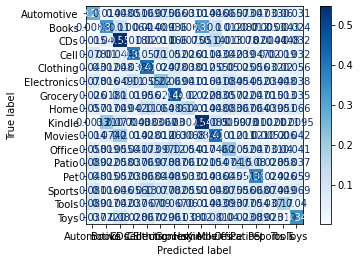

Accuracy: 0.3122262826950242


In [38]:
disp = plot_confusion_matrix(clf_all, X_test_fm.loc[y_test.index], df.category.loc[y_test.index],
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize="true")
#disp.ax_.set_title(category)

#print(disp.confusion_matrix)
plt.show()


print("Accuracy:", clf_all.score(X_test_fm, df.category.loc[y_test.index]))


In [39]:
import nltk
#nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(["door"])

[('door', 'NN')]

In [40]:
idf_scores.loc["After", "scores"]

6.551204818477387

Filter words out if there have less than 15% occurrences in one category and only nouns and verbs:
Problems with that:
- There might be words that are just used in those categories, but male and female use them differently 
- There are words that are used in male/female categories and therefore occur more frequently (should those be filtered out?)